<a href="https://colab.research.google.com/github/cjaradhye/hackbattlethe2nd/blob/main/stegos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import os

if(not os.path.exists("/content/drive/MyDrive/stegos_datasets/div2k_zips")):
  !wget -P /content/drive/MyDrive/stegos_datasets/div2k_zips http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
  !wget -P /content/drive/MyDrive/stegos_datasets/div2k_zips http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip

In [16]:
if(not os.path.exists("/content/drive/MyDrive/stegos_datasets/DIV2K_train_HR")):
  !unzip /content/drive/MyDrive/Colab\ Notebooks/stegos_datasets/div2k_zips/DIV2K_train_HR.zip -d /content/drive/MyDrive/Colab\ Notebooks/stegos_datasets
  !unzip /content/drive/MyDrive/Colab\ Notebooks/stegos_datasets/div2k_zips/DIV2K_valid_HR.zip -d /content/drive/MyDrive/Colab\ Notebooks/stegos_datasets

In [17]:
import os

_, _, files_train = next(os.walk("/content/drive/MyDrive/stegos_datasets/DIV2K_train_HR"))
_, _, files_test = next(os.walk("/content/drive/MyDrive/stegos_datasets/DIV2K_valid_HR"))

print(f"Train {len(files_train)}")
print(f"Test {len(files_test)}")

Train 800
Test 100


In [18]:
def strToTensor(string, height, width):
  asciiArr = [ord(char) for char in string]

  normVals = [ascii / 255 for ascii in asciiArr]
  paddedVals = normVals + [0] * (height * width - len(normVals))

  tensor = torch.tensor(paddedVals).float().reshape(1, 1, height, width)

  return tensor

In [19]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

class Encoder(nn.Module):

  def __init__(self):
    super(Encoder, self).__init__()
    self.conv1 = nn.Sequential(
      nn.Conv2d(
        in_channels = 3,
        out_channels = 32,
        kernel_size = 5,
        padding = 1
      ),
      nn.ReLU()
    )

    self.conv2 = nn.Sequential(
      nn.Conv2d(
        in_channels = 33,
        out_channels = 33,
        kernel_size = 5,
        padding = 1
      ),
      nn.ReLU()
    )

    self.conv3 = nn.Conv2d(
      in_channels = 33,
      out_channels = 3,
      kernel_size = 5,
      padding = 1
    )


  def forward(self, img, string):
    out = self.conv1(img)
    data = strToTensor(string, out.shape[2], out.shape[3])
    print(out.shape, data.shape)
    out = torch.cat([out, data], dim=1)
    print(out.shape)
    out = self.conv2(out)
    print(out.shape)
    out = self.conv3(out)

    return out

In [29]:
from PIL import Image
from torchvision import transforms

img = Image.open("/content/drive/MyDrive/stegos_datasets/IMG_20240925_165530129.jpg")

transform = transforms.ToTensor()
imgTensor = transform(img)
imgTensor = imgTensor.unsqueeze(0)
imgTensor.shape

model = Encoder()
string = "Hello, world!"
binaryString = " ".join(map(bin,bytearray(string,'utf8')))
out = model(imgTensor, binaryString)

torch.Size([1, 32, 4078, 2294]) torch.Size([1, 1, 4078, 2294])
torch.Size([1, 33, 4078, 2294])
torch.Size([1, 33, 4076, 2292])


In [30]:
print(img.size)
print(imgTensor.shape)
print(out.shape)

(2296, 4080)
torch.Size([1, 3, 4080, 2296])
torch.Size([1, 3, 4074, 2290])


2290 4074 RGB None


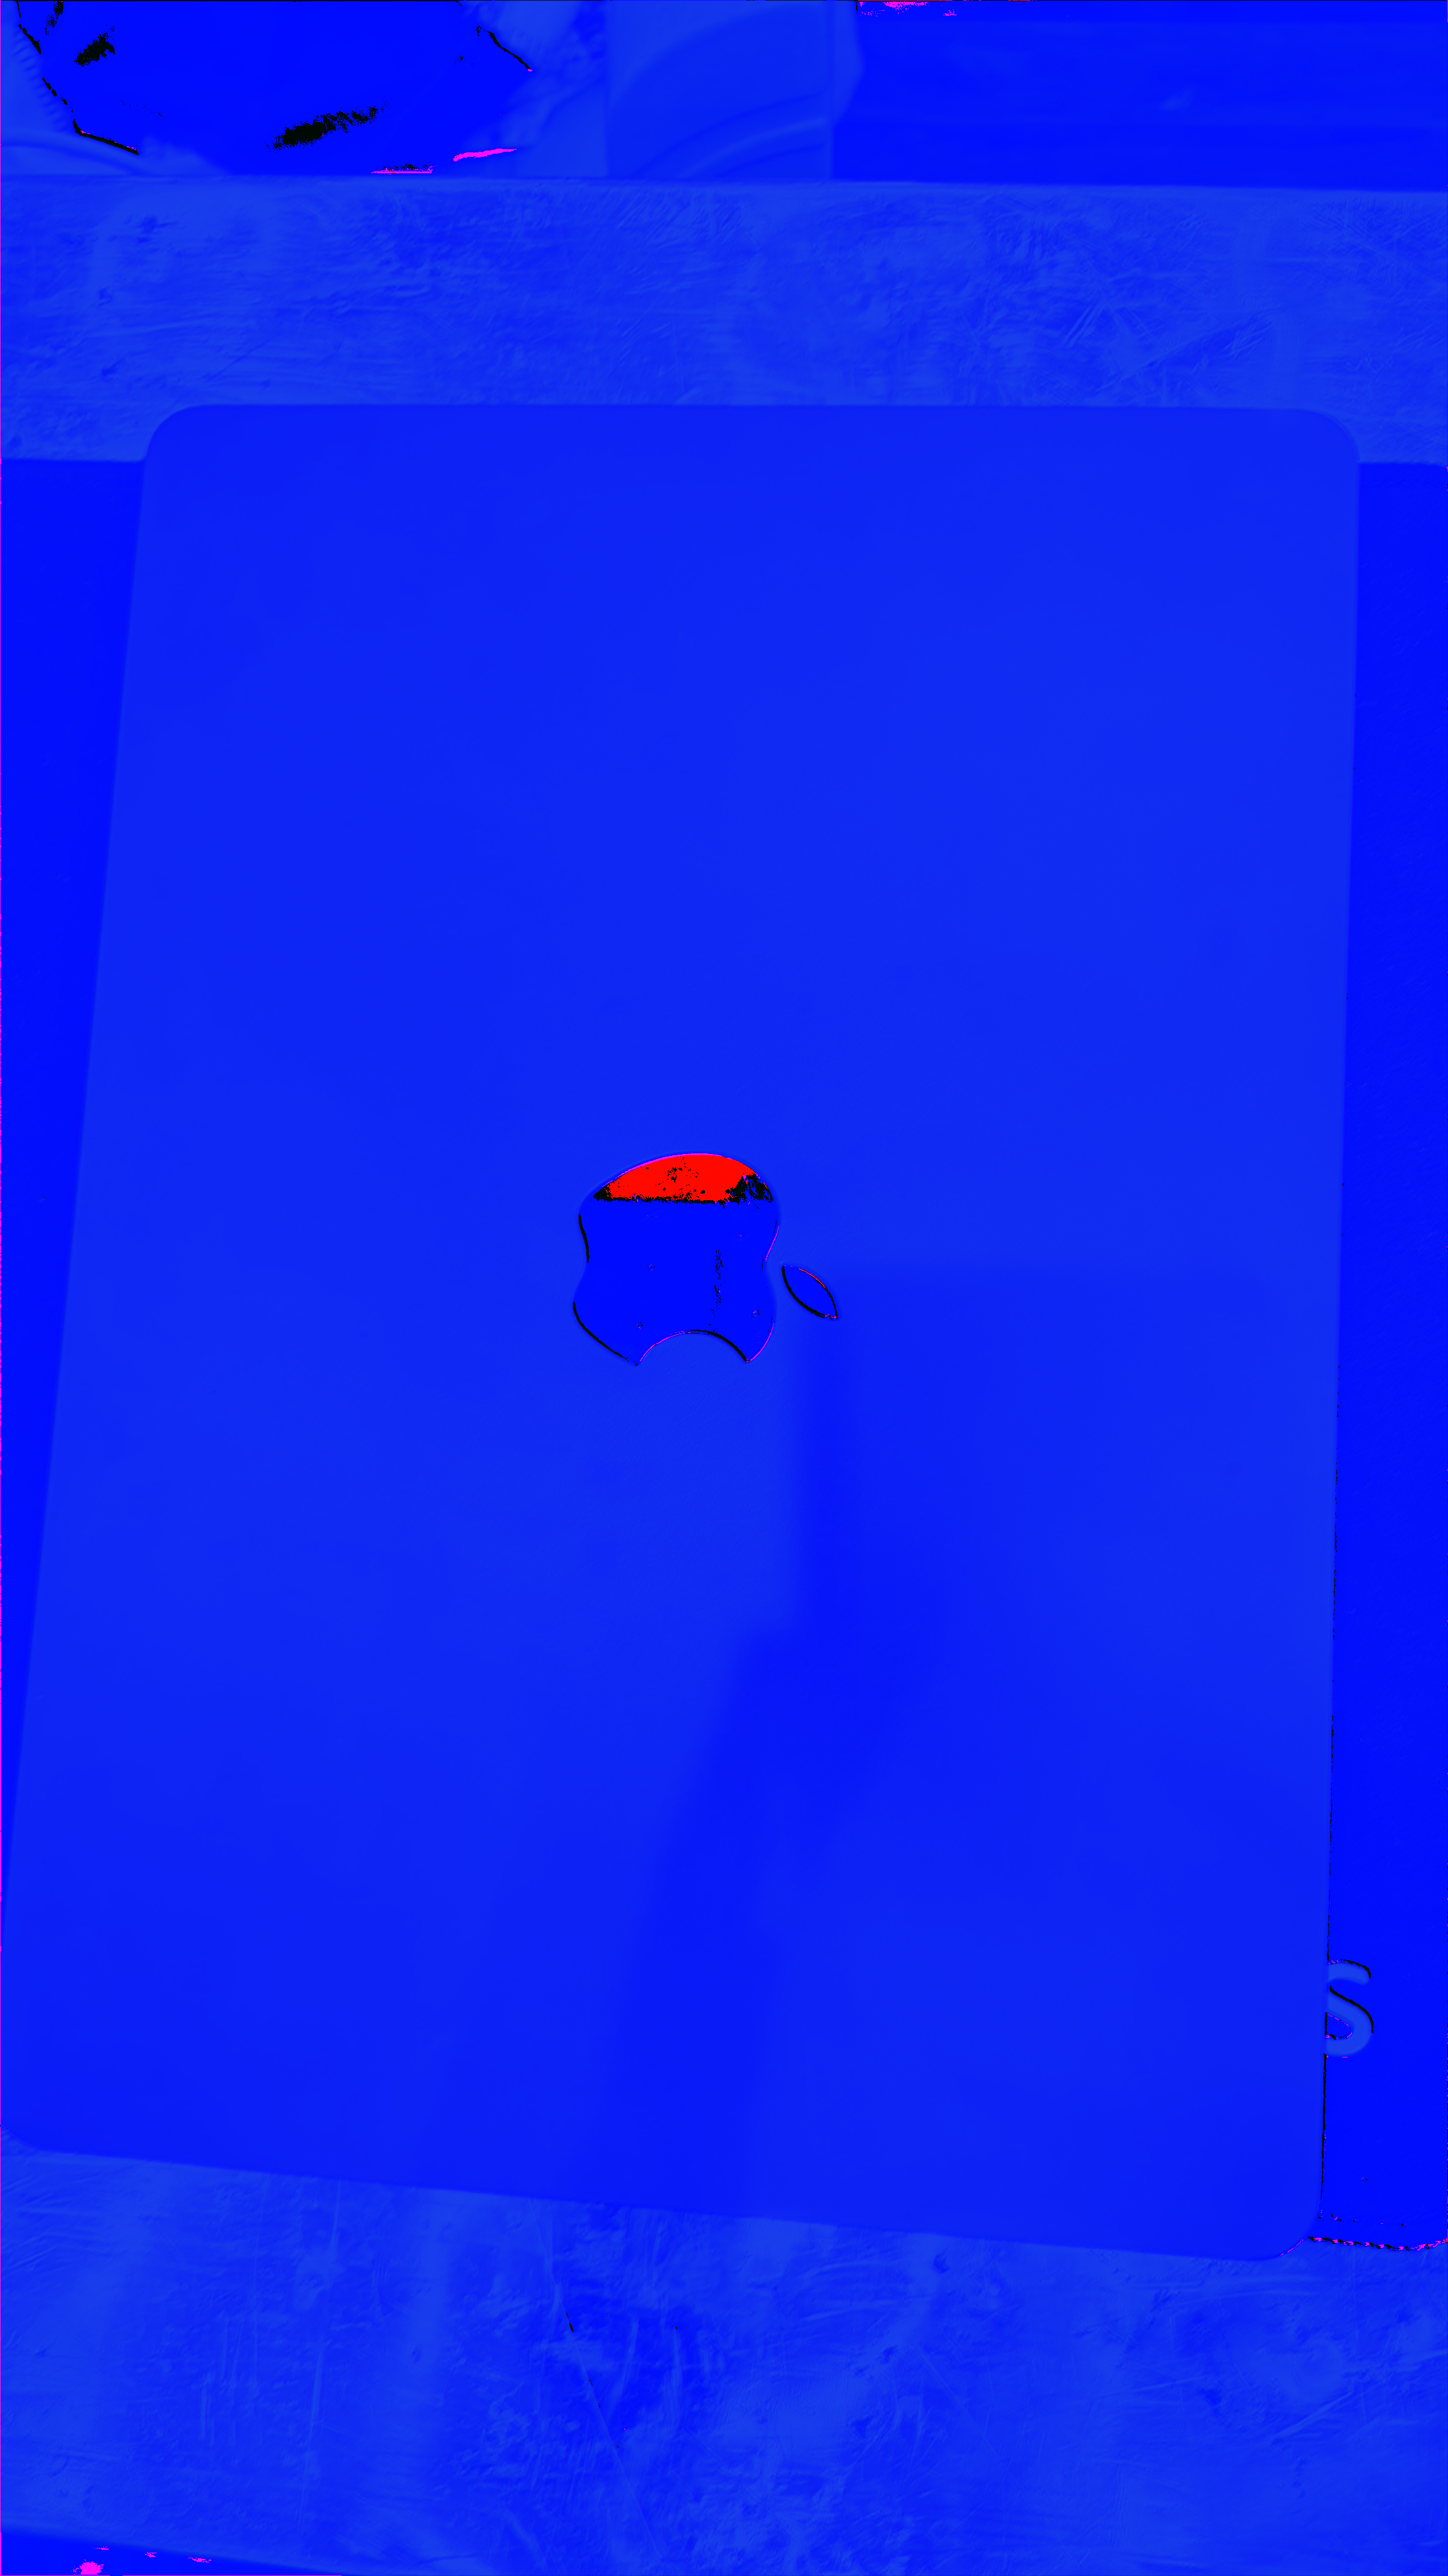

In [31]:
transform = transforms.ToPILImage()
encodedImg = transform(out.squeeze(0))

print(encodedImg.width, encodedImg.height, encodedImg.mode, encodedImg.format)
encodedImg

In [27]:
class Decoder(nn.Module):

  def __init__(self):
    super(Decoder, self).__init__()
    self.conv1 = nn.Sequential(
      nn.Conv2d(
        in_channels = 3,
        out_channels = 32,
        kernel_size = 5,
        padding = 1
      ),
      nn.ReLU()
    )

    self.conv2 = nn.Sequential(
      nn.Conv2d(
        in_channels = 32,
        out_channels = 32,
        kernel_size = 5,
        padding = 1
      ),
      nn.ReLU()
    )

    self.conv3 = nn.Sequential(
      nn.Conv2d(
        in_channels = 32,
        out_channels = 32,
        kernel_size = 5,
        padding = 1
      ),
      nn.ReLU()
    )

    self.conv4 = nn.Conv2d(
      in_channels = 32,
      out_channels = 3,
      kernel_size = 5,
      padding = 1
    )


  def forward(self, img):
    out = self.conv1(img)
    out = self.conv2(out)
    out = self.conv3(out)
    out = self.conv4(out)

    return out

In [28]:
class Critic(nn.Module):

  def __init__(self):
    super(Critic, self).__init__()
    self.conv1 = nn.Sequential(
      nn.Conv2d(
        in_channels = 3,
        out_channels = 32,
        kernel_size = 5,
        padding = 1
      ),
      nn.ReLU()
    )

    self.conv2 = nn.Sequential(
      nn.Conv2d(
        in_channels = 32,
        out_channels = 32,
        kernel_size = 5,
        padding = 1
      ),
      nn.ReLU()
    )

    self.conv3 = nn.Sequential(
      nn.Conv2d(
        in_channels = 32,
        out_channels = 32,
        kernel_size = 5,
        padding = 1
      ),
      nn.ReLU()
    )

    self.conv4 = nn.Conv2d(
      in_channels = 32,
      out_channels = 3,
      kernel_size = 5,
      padding = 1
    )


  def forward(self, img):
    out = self.conv1(img)
    out = self.conv2(out)
    out = self.conv3(out)
    out = self.conv4(out)

    return torch.mean(out.view(out.shape(0), -1), dim=1)